<a href="https://colab.research.google.com/github/tntly/ml-projects/blob/main/wine_quality_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wine Quality Multi-class Classification

This notebook implements a neural network to classify wine quality into 5 categories: Low, Medium-Low, Medium, Medium-High, and High. It was created as part of my coursework for CS 271: Topics in Machine Learning at San Jose State University.

## Section 1: Setup and Data Loading

In [4]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [92]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For preprocessing and model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [93]:
# Load dataset
wine = pd.read_csv("/content/drive/MyDrive/CS 271/Assignments/wine_quality.csv")

## Section 2: Exploratory Data Analysis

In [94]:
# Display first few rows
print("Preview of the dataset:")
display(wine.head())

# Dataset information
print("\nDataset information:")
wine.info()

# Statistical summary
print("\nStatistical summary:")
display(wine.describe())

# Check class distribution
print("\nClass distribution:")
print(wine["quality"].value_counts(ascending=True))

Preview of the dataset:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.291114,0.486442,0.300503,0.900000,0.015739,10.119501,83.835280,0.997348,3.390186,0.654920,8.809257,Medium-High
1,8.750731,0.548988,0.264489,2.257949,0.114811,24.012219,6.000000,0.995788,3.320167,0.552764,9.220956,Medium-High
2,7.121011,0.416757,0.171422,2.447964,0.069355,5.883556,54.381763,0.995753,3.067723,0.675910,10.867600,Medium
3,11.325877,0.397869,0.008664,2.483803,0.156098,23.928658,98.454793,0.998876,3.399212,0.930702,13.376553,Medium
4,6.806398,0.597507,0.365772,3.219262,0.021520,1.000000,44.882639,0.995727,3.172473,0.863165,10.244412,Medium-High



Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5000 non-null   float64
 1   volatile acidity      5000 non-null   float64
 2   citric acid           5000 non-null   float64
 3   residual sugar        5000 non-null   float64
 4   chlorides             5000 non-null   float64
 5   free sulfur dioxide   5000 non-null   float64
 6   total sulfur dioxide  5000 non-null   float64
 7   density               5000 non-null   float64
 8   pH                    5000 non-null   float64
 9   sulphates             5000 non-null   float64
 10  alcohol               5000 non-null   float64
 11  quality               5000 non-null   object 
dtypes: float64(11), object(1)
memory usage: 468.9+ KB

Statistical summary:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,8.349835,0.526379,0.276535,2.594706,0.088236,16.260726,48.690879,0.996768,3.311366,0.658122,10.461020
std,1.717194,0.176106,0.183769,1.273142,0.044430,9.735590,30.425146,0.001856,0.155415,0.166482,1.033777
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.195541,0.404292,0.132661,1.539660,0.055164,8.892291,23.982949,0.995522,3.204367,0.540422,9.737473
50%,8.337575,0.526369,0.264508,2.510346,0.086996,16.030426,47.035699,0.996744,3.312448,0.657467,10.426220
75%,9.520339,0.646922,0.403052,3.469872,0.118883,22.933460,69.755513,0.998018,3.415951,0.770503,11.159249
max,15.417004,1.198324,0.936551,7.994076,0.251429,53.003917,163.287601,1.004006,3.836557,1.245648,14.370318



Class distribution:
quality
High             50
Low             163
Medium-High     620
Medium         2016
Medium-Low     2151
Name: count, dtype: int64


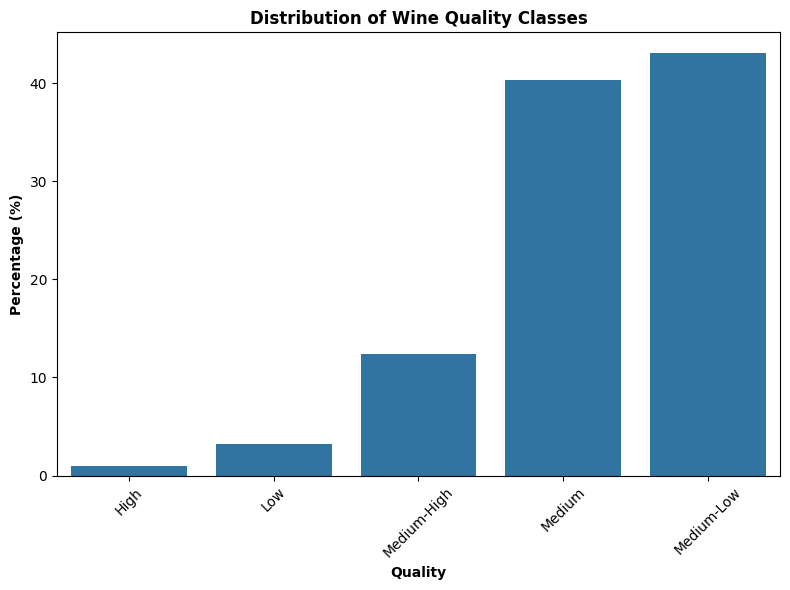

In [95]:
# Visualize class distribution
plt.figure(figsize=(8, 6))

sns.countplot(data=wine,
              x="quality",
              order=wine["quality"].value_counts(ascending=True).index,
              stat="percent")

plt.xlabel("Quality", fontweight='bold')
plt.ylabel("Percentage (%)", fontweight='bold')
plt.title("Distribution of Wine Quality Classes", fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()

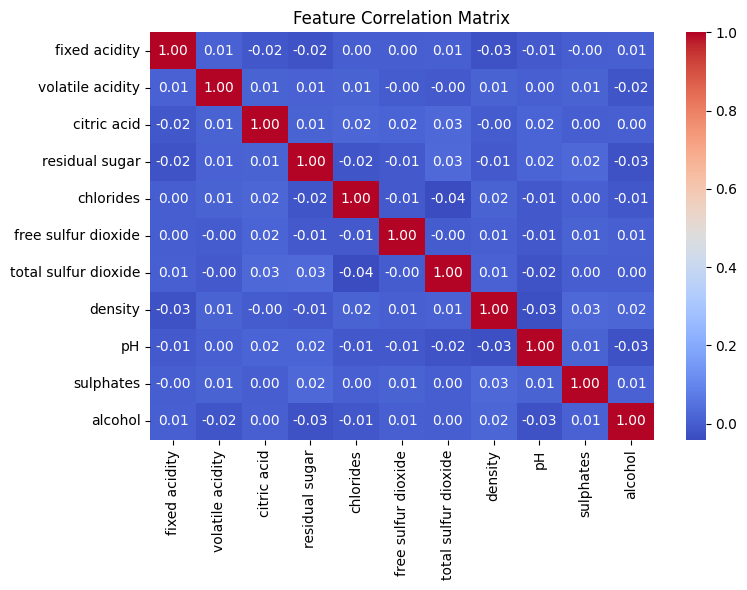

In [96]:
# Correlation analysis
plt.figure(figsize=(8, 6))

correlation = wine.drop(columns=["quality"]).corr()
sns.heatmap(correlation, cmap="coolwarm", annot=True, fmt=".2f")

plt.title("Feature Correlation Matrix")
plt.tight_layout()

## Section 3: Data Preprocessing

In [97]:
# Check for missing values
print("Missing values per column:")
print(wine.isnull().sum())

Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [98]:
# Define custom mapping for class labels (ordinal encoding)
quality_mapping = {
    "Low": 0,
    "Medium-Low": 1,
    "Medium": 2,
    "Medium-High": 3,
    "High": 4
}

# Apply the mapping to the quality column
wine["quality_encoded"] = wine["quality"].map(quality_mapping)
print("\nAfter encoding:")
display(wine.head())


After encoding:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_encoded
0,8.291114,0.486442,0.300503,0.900000,0.015739,10.119501,83.835280,0.997348,3.390186,0.654920,8.809257,Medium-High,3
1,8.750731,0.548988,0.264489,2.257949,0.114811,24.012219,6.000000,0.995788,3.320167,0.552764,9.220956,Medium-High,3
2,7.121011,0.416757,0.171422,2.447964,0.069355,5.883556,54.381763,0.995753,3.067723,0.675910,10.867600,Medium,2
3,11.325877,0.397869,0.008664,2.483803,0.156098,23.928658,98.454793,0.998876,3.399212,0.930702,13.376553,Medium,2
4,6.806398,0.597507,0.365772,3.219262,0.021520,1.000000,44.882639,0.995727,3.172473,0.863165,10.244412,Medium-High,3


In [99]:
# Initialize the StandardScaler for feature normalization
scaler = StandardScaler()

# Separate features and target
X = wine.drop(columns=["quality", "quality_encoded"])
feature_names = X.columns  # Store feature names for later use
y = wine["quality_encoded"]

# Normalize features
X = scaler.fit_transform(X)

In [138]:
# # Split the dataset into training, validation, and test sets (80% training, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Class distribution in training set
print("\nClass distribution in training set:")
print(y_train.value_counts().sort_index())

Training set size: 4000 samples
Validation set size: 500 samples
Test set size: 500 samples

Class distribution in training set:
quality_encoded
0     130
1    1721
2    1613
3     496
4      40
Name: count, dtype: int64


## Section 4: PyTorch Data Preparation

In [139]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long) # Long type for classification

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [174]:
BATCH_SIZE = 32

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [141]:
# Set computation device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Section 5: Model Definition

In [202]:
class WineQualityModel(nn.Module):
  """
  Neural network model for wine quality classification

  Architecture:
  - Input layer: Feature dimension
  - Hidden layer 1: 64 neurons with ReLU activation
  - Hidden layer 2: 32 neurons with ReLU activation
  - Dropout layer with 0.3 probability (to prevent overfitting)
  - Output layer: 5 neurons (one per class)
  """
  def __init__(self, input_features, num_classes, hidden_size1=32, hidden_size2=32, dropout_rate=0.3):
    super().__init__()
    self.fc1 = nn.Linear(input_features, hidden_size1)  # First hidden layer
    self.fc2 = nn.Linear(hidden_size1, hidden_size2)    # Second hidden layer
    self.dropout = nn.Dropout(dropout_rate)             # Dropout for regularization
    self.fc3 = nn.Linear(hidden_size2, num_classes)     # Output layer

    # Initialize weights using He initialization
    nn.init.kaiming_uniform_(self.fc1.weight)
    nn.init.kaiming_uniform_(self.fc2.weight)
    nn.init.xavier_uniform_(self.fc3.weight)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropout(x) # Apply dropout only during training
    x = self.fc3(x)

    return x

In [203]:
# Initialize the model
input_dim = X_train.shape[1]
num_classes = y_train.nunique()
model = WineQualityModel(input_features=input_dim, num_classes=num_classes).to(device)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss() # Standard loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # Added weight decay for regularization

# Learning rate scheduler to reduce LR when training plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=True
)

WineQualityModel(
  (fc1): Linear(in_features=11, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=5, bias=True)
)


## Section 6: Training and Evaluation Functions

In [156]:
def train_epoch(model, dataloader, criterion, optimizer, device):
  """Train model for one epoch"""
  model.train()

  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # Statistics
    running_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(outputs, dim=1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  epoch_loss = running_loss / total
  epoch_accuracy = 100 * correct / total
  return epoch_loss, epoch_accuracy

In [146]:
def evaluate(model, dataloader, criterion, device):
  """Evaluate model performance"""
  model.eval()

  running_loss = 0.0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      # Statistics
      running_loss += loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  epoch_loss = running_loss / total
  epoch_accuracy = 100 * correct / total
  return epoch_loss, epoch_accuracy, all_preds, all_labels

## Section 7: Model Training

In [204]:
# Training parameters
NUM_EPOCHS = 100
best_accuracy = 0.0
early_stopping_counter = 0
early_stopping_patience = 15

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
print("Starting training...")
for epoch in range(NUM_EPOCHS):
  # Train one epoch
  train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  # Evaluate on validation set
  val_loss, val_accuracy, _, _ = evaluate(model, val_loader, criterion, device)
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  # Update learning rate scheduler
  scheduler.step(val_loss)

  # Print metrics
  print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
  print(f"  Train loss: {train_loss:.4f}. Train accuracy: {train_accuracy:.2f}%")
  print(f"  Validation loss: {val_loss:.4f}. Validation accuracy: {val_accuracy:.2f}%")

  # Save best model
  if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    torch.save(model.state_dict(), "/content/drive/MyDrive/CS 271/Assignments/best_wine_quality_model.pt")
    print(f"  Saved new best model with accuracy: {best_accuracy:.2f}%")
    early_stopping_counter = 0
  else:
    early_stopping_counter += 1

  # Early stopping
  if early_stopping_counter >= early_stopping_patience:
    print(f"Early stopping triggered after {epoch+1} epochs")
    break

# Load best model for evaluation
model.load_state_dict(torch.load("/content/drive/MyDrive/CS 271/Assignments/best_wine_quality_model.pt"))

Starting training...
Epoch 1/100
  Train loss: 1.6606. Train accuracy: 36.40%
  Validation loss: 1.2388. Validation accuracy: 41.20%
  Saved new best model with accuracy: 41.20%
Epoch 2/100
  Train loss: 1.3182. Train accuracy: 41.00%
  Validation loss: 1.2009. Validation accuracy: 40.40%
Epoch 3/100
  Train loss: 1.2542. Train accuracy: 42.67%
  Validation loss: 1.1830. Validation accuracy: 39.80%
Epoch 4/100
  Train loss: 1.2118. Train accuracy: 43.02%
  Validation loss: 1.1727. Validation accuracy: 39.00%
Epoch 5/100
  Train loss: 1.1989. Train accuracy: 44.12%
  Validation loss: 1.1675. Validation accuracy: 41.00%
Epoch 6/100
  Train loss: 1.1829. Train accuracy: 43.58%
  Validation loss: 1.1630. Validation accuracy: 41.00%
Epoch 7/100
  Train loss: 1.1779. Train accuracy: 43.85%
  Validation loss: 1.1631. Validation accuracy: 41.00%
Epoch 8/100
  Train loss: 1.1672. Train accuracy: 44.40%
  Validation loss: 1.1603. Validation accuracy: 41.20%
Epoch 9/100
  Train loss: 1.1634. Trai

<All keys matched successfully>

## Section 8: Evaluation and Results

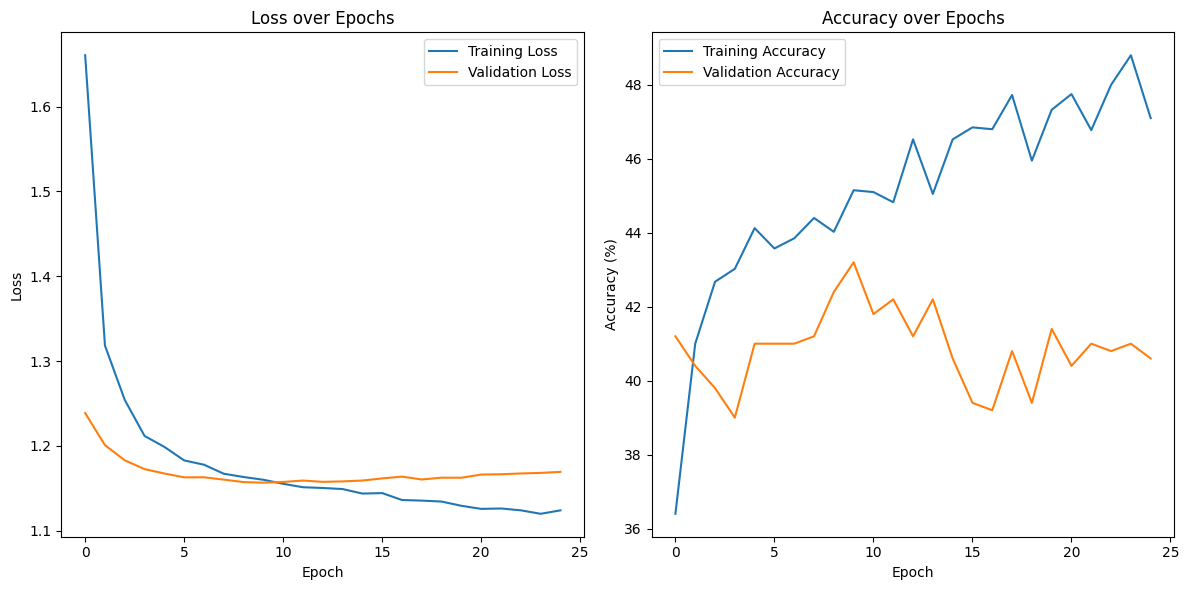

In [208]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()

In [206]:
# Final evaluation on test set
test_loss, test_accuracy, y_pred, y_true = evaluate(model, test_loader, criterion, device)
print(f"Final test accuracy: {test_accuracy:.2f}%")

Final test accuracy: 43.60%


## Section 9: Feature Importance Analysis

In [210]:
# A simple method to estimate feature importance
def analyze_feature_importance(model, feature_names):
  # Get weights from the first layer
  weights = model.fc1.weight.detach().cpu().numpy()

  # Calculate absolute mean impact per feature
  importance = np.abs(weights).mean(axis=0)

  # Create a DataFrame to store feature importance
  feature_importance = pd.DataFrame({
      "Feature": feature_names,
      "Importance": importance
  }).sort_values(by="Importance", ascending=False)

  return feature_importance

In [212]:
# Get feature importance
feature_importance = analyze_feature_importance(model, feature_names)

print("Feature Importance:")
print(feature_importance)

Feature Importance:
                 Feature  Importance
4              chlorides    0.361489
9              sulphates    0.360287
2            citric acid    0.359296
7                density    0.349354
0          fixed acidity    0.344644
8                     pH    0.342119
3         residual sugar    0.336998
6   total sulfur dioxide    0.325566
5    free sulfur dioxide    0.322758
10               alcohol    0.304312
1       volatile acidity    0.291750


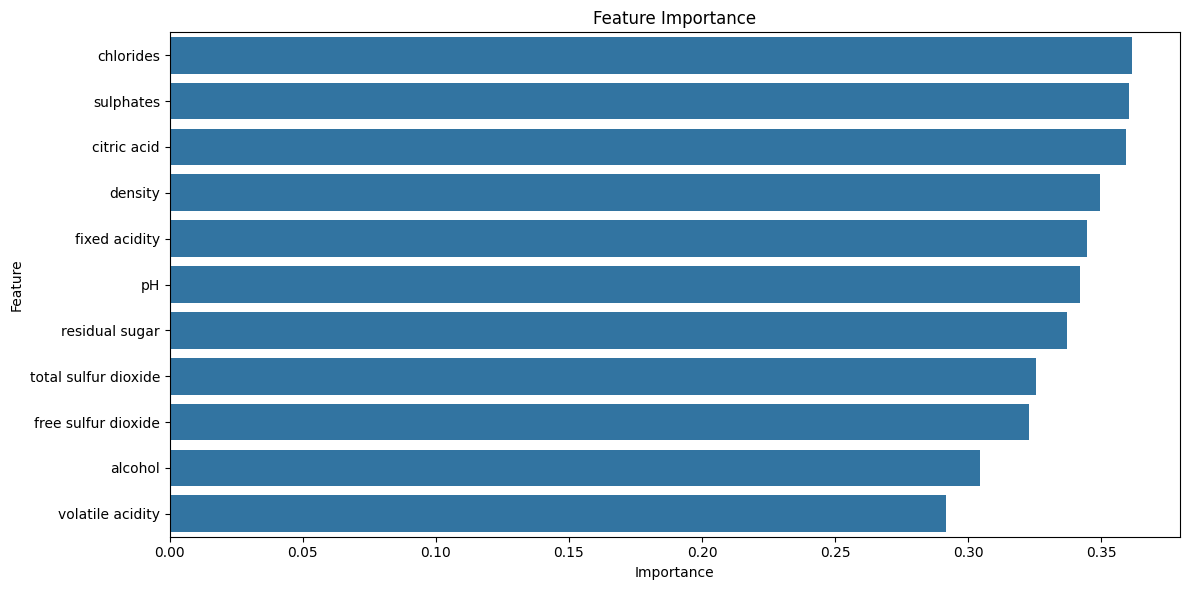

In [214]:
# Plot feature importance
plt.figure(figsize=(12, 6))

sns.barplot(data=feature_importance,
            x="Importance",
            y="Feature")

plt.title("Feature Importance")
plt.tight_layout()